In [282]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report

from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FastICA

from sklearn.random_projection import SparseRandomProjection as RCA
from collections import defaultdict
from itertools import product
from sklearn.metrics.pairwise import pairwise_distances
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.ensemble import RandomForestClassifier

import timeit
import os

from sklearn.exceptions import ConvergenceWarning, DataDimensionalityWarning,UndefinedMetricWarning
import warnings


from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from libs.loader import load_malicious, load_jobchange, load_jobchange_test_untouched, load_malicious_test_untouched, load_jobchange_w_headers, load_malicious_w_headers
         

from sklearn.model_selection import learning_curve, validation_curve

In [283]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=DataDimensionalityWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning, module="sklearn")

warnings.filterwarnings("ignore", category=RuntimeWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [284]:
#Load the two datset
job_data = load_jobchange()
mal_data = load_malicious()

_X_job,y_job = job_data
_X_mal,y_mal = mal_data


minMaxNorm = MinMaxScaler()
X_job = minMaxNorm.fit_transform(_X_job)
X_mal = minMaxNorm.fit_transform(_X_mal)

_X_test_mal, y_test_mal = load_malicious_test_untouched()
_X_test_job, y_test_job = load_jobchange_test_untouched()
X_test_mal = minMaxNorm.fit_transform(_X_test_mal)
X_test_job = minMaxNorm.fit_transform(_X_test_job)

RND_STATE=998756

def get_data_sizes(X, X_test):
    r,c = X.shape
    r_t, _ = X_test.shape
    return r+r_t, r, r_t, c
print('****Data sizes\n Mal total/train/test: (%d/%d/%d)columns: (%d) '%get_data_sizes(X_mal, X_test_mal))
print('****Data sizes\n Job total/train/test: (%d/%d/%d)columns: (%d) '%get_data_sizes(X_job, X_test_job))

PLOT_DIR = 'plots/em'
OUTPUT_DIR = 'output'
DR_DIR = 'plots/dr'
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DR_DIR, exist_ok=True)


****Data sizes
 Mal total/train/test: (23856/19084/4772)columns: (15) 
****Data sizes
 Job total/train/test: (19158/15326/3832)columns: (12) 


In [209]:
RESULTS = {}

In [226]:
def max_kurtosis_indexes(X_projected, cutoff):
    tmp = pd.DataFrame(X_projected)
    tmp = tmp.kurt(axis=0)
    kurt = tmp.sort_values(ascending=False)
        
    max_k = kurt[0:cutoff]
    print(f"Top-{cutoff} Max Kurtosis -- ")
    print(max_k)
    print(max_k.index)
    return max_k.index
    
    

In [227]:
def ica_max_kurtosis(X, cutoff, dim=0):

    if dim == 0:
        dim = X.shape[1]-1
    elif dim < cutoff:
        dim = cutoff

    ica = FastICA(random_state=89143)
    ica.set_params(n_components=dim)
    X_projected = ica.fit_transform(X)

    max_k_idexes = max_kurtosis_indexes(X_projected,cutoff)
    
    X_proj_df = pd.DataFrame(X_projected)
    X_proj_df  = X_proj_df.filter( max_k_idexes, axis=1 )
        
    return X_proj_df
    

In [228]:
def pca(X, cutoff_per, var_threashold):
    pca = PCA(cutoff_per, random_state=5)
    pca.fit(X)
    pca.explained_variance_

    row_index = range(1, pca.explained_variance_.shape[0] + 1)
    ev = pd.Series(data=pca.explained_variance_, index=row_index)
    evr = pd.Series(data=pca.explained_variance_ratio_, index=row_index)
    eigen = pd.Series(data=pca.singular_values_, index=row_index)

    
    pca_stats_df = pd.DataFrame()
    pca_stats_df['pca_stats_df'] = ev
    pca_stats_df['e-variance-ratio'] = evr
    pca_stats_df['eigen'] = eigen

    var_above = pca_stats_df[pca_stats_df['pca_stats_df'] >= var_threashold]
    print("Original PCA components")
    print(pca_stats_df)
    print(f"Threshold PCA components variance >= [{var_threashold:.2f}%]")
    print(var_above)
  
    constrained_cols = var_above.index-1
    X_pca_projected = pca.transform(X)

    return pd.DataFrame(X_pca_projected).filter(constrained_cols, axis=1)


In [229]:
def rp(X, dim, r_state=RND_STATE):
    rp = RCA(random_state=r_state, n_components=dim)
    fitted = rp.fit(X)
    X_rca_projected = rp.transform(X)
    return pd.DataFrame(X_rca_projected)
    

In [230]:
def rfc_research(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RND_STATE, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_

#         important_features = pd.Series(np.sort(fs)[::-1])
        return fs
        
def rfc(X,y):
                 
        rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RND_STATE, n_jobs=-1)
        fs = rfc.fit(X,y).feature_importances_
        indexes_found = np.where(fs >= 0.10)
        
        X_reduced = pd.DataFrame(X)
        X_reduced = X_reduced.filter(indexes_found[0], axis=1)
        return X_reduced

In [232]:

#KEY CODE BLOCK!!!
print(f"---- RUNNING ICA -------")
X_ica_proj_mal = ica_max_kurtosis(X_mal ,3, dim=12)  #golden (X_mal ,3, dim=12)
X_ica_proj_mal_test = ica_max_kurtosis(X_test_mal, 3, dim=12) #golden (X_mal ,3, dim=12)

print(f"\n---- RUNNING PCA -------")
X_pca_proj_mal = pca(X_mal, 0.80, 0.08)
X_pca_proj_mal_test = pca(X_test_mal, 0.80, 0.08)
 
print(f"\n---- RUNNING RP -------")
r_states = [89143, 92, 1081244453, 8772, 212]
X_rp_proj_mal_list = [];
X_rp_proj_mal_test_list = [];

for r in r_states:
    X_rp_mal = rp(X_mal,3, r)
    X_rp_mal_test = rp(X_test_mal,3, r)

    X_rp_proj_mal_list.append(X_rp_mal)
    X_rp_proj_mal_test_list.append(X_rp_mal_test)

print(f"\n---- RUNNING Random Forest RFC -------")
X_rfc_proj_mal = rfc(X_mal,y_mal)
X_rfc_proj_mal_test = rfc(X_test_mal, y_test_mal)


---- RUNNING ICA -------
Top-3 Max Kurtosis -- 
4     979.059926
10     16.442754
3       9.372346
dtype: float64
Int64Index([4, 10, 3], dtype='int64')
Top-3 Max Kurtosis -- 
2    342.083547
6     15.910989
3      8.838629
dtype: float64
Int64Index([2, 6, 3], dtype='int64')

---- RUNNING PCA -------
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.233921          0.268764  66.812563
2      0.126357          0.145178  49.104657
3      0.104607          0.120188  44.679041
4      0.098900          0.113632  43.443266
5      0.077852          0.089448  38.544098
6      0.057066          0.065566  32.999864
Threshold PCA components variance >= [0.08%]
   pca_stats_df  e-variance-ratio      eigen
1      0.233921          0.268764  66.812563
2      0.126357          0.145178  49.104657
3      0.104607          0.120188  44.679041
4      0.098900          0.113632  43.443266
Original PCA components
   pca_stats_df  e-variance-ratio      eigen
1      0.233873      

In [233]:

#Malicious data
y_mlp = y_mal
y_mlp_test = y_test_mal
scorer = make_scorer(recall_score)



In [234]:
def quiet_stats(estimator, X_data, y_data ):
    predicted = estimator.predict(X_data)
    recall_0 = recall_score(y_data, predicted, pos_label=0)
    recall_1 = recall_score(y_data, predicted)
    c_matrix = confusion_matrix(y_data, predicted)
    return recall_0, recall_1, c_matrix

def train_and_stats(label, mlp_cls, X, y):
    start_time = timeit.default_timer()
    mlp_trained = mlp_cls.fit(X, y)
    end_time = timeit.default_timer()
    total_time = end_time - start_time
    
    rc0, rc1, cnfm = quiet_stats(mlp_cls, X, y)
    
    return mlp_trained.n_iter_, total_time, rc0, rc1, cnfm
    
def loop_quiet_stats(estimator, X_data_list, y_data, X_data_test_list, y_test_data):
    
    results = {}
    df_holder = pd.DataFrame()
    for i in range(len(X_data_list)):
        print(f" --- Starting iteration [{i}]")
        start_time = timeit.default_timer()
        mlp_trained = estimator.fit(X_data_list[i], y_data)
        end_time = timeit.default_timer()
        total_time = end_time - start_time
        r0, r1, _ = quiet_stats(mlp_trained, X_data_list[i], y_data)
        results['total_time'] , results['iterations']= total_time, mlp_trained.n_iter_
        results['recall_0'],results['recall_1']=  r0, r1
        r0_t, r1_t, _ = quiet_stats(mlp_trained, X_data_test_list[i], y_test_data)
        results['recall_0_test'], results['recall_1_test']=  r0_t, r1_t
        df_holder = df_holder.append(results, ignore_index=True)
    
    return df_holder


In [235]:
def stats_pac( label, estimator, X_data, y_data ):
    predicted = estimator.predict(X_data)
    print ('****** %s ******' % label)
    print ('Confusion matrix\n', confusion_matrix(y_data, predicted))
    
    print ('Recall - label 0: %0.4f'% recall_score(y_data, predicted, pos_label=0))
    print ('Recall - label 1: %0.4f'% recall_score(y_data, predicted))

#     print ('Precsion - label 0: %0.4f'% precision_score(y_data, predicted, pos_label=0))
#     print ('Precsion - label 1: %0.4f'% precision_score(y_data, predicted))
    
#     sample_wt = [ 3 if i == 1 else 1 for i in predicted]
#     print ('F1 Score macro: %0.4f'% f1_score(y_data, predicted, average='macro', sample_weight=sample_wt ))
#     print ('F1 Score - label 0 : %0.4f'% f1_score(y_data, predicted, pos_label=0 ))
#     print ('F1 Score - label 1 : %0.4f'% f1_score(y_data, predicted, pos_label=1 ))
#     print ('F1 Score - weighted avg : %0.4f'% f1_score(y_data, predicted, average='weighted' ))
#     print ('F1 Beta - b=2 weighted avg : %0.4f'% fbeta_score(y_data,predicted, average='weighted', beta=2))
    
    print (classification_report(y_data, predicted, labels=[0,1]))


In [236]:

def train_and_print_stats(label, mlp_cls, X, y):
    start_time = timeit.default_timer()
    mlp_trained = mlp_cls.fit(X, y)
    end_time = timeit.default_timer()
    total_time = end_time - start_time
    
    print ('****** %s ******' % label)
    print ('Total Iterations %d'% mlp_trained.n_iter_)
    print ('Total Train Time %.3f'% total_time)
    
    stats_pac(label, mlp_trained, X, y)
    return mlp_trained

    

In [237]:
def save_results(key, r1, r2):
    iter_cnt, time, r0_train, r1_train, confuse_train =r1
    r0_test, r1_test, confuse_test = r2
    RESULTS[key] = {'iter_cnt':iter_cnt, 'time':time, 'r1':r1_train, 'r1_t':r1_test}
    
def run_nn_classifier(title, r_key, estimator, X_train, X_test):
    train_out = train_and_stats(title, estimator, X_train, y_mlp)
    test_out = quiet_stats(estimator, X_test, y_mlp_test)
    save_results(r_key, train_out, test_out)

    

In [238]:
#RAW NN
mlp_RAW_target = MLPClassifier(hidden_layer_sizes=(199,), max_iter=2000, random_state=RND_STATE)
run_nn_classifier('MLP - Raw Malicious',  'nn_raw', mlp_RAW_target,  X_mal, X_test_mal)

#PCA NN
mlp_PCA_target = MLPClassifier(hidden_layer_sizes=(300,20), max_iter=2000, random_state=RND_STATE)
run_nn_classifier('MLP PCA Malicious',  'nn_pca', mlp_PCA_target,  X_pca_proj_mal, X_pca_proj_mal_test)


#ICA NN
mlp_ICA_target = MLPClassifier(hidden_layer_sizes=(300,10), max_iter=2000, random_state=RND_STATE)
# mlp_ICA_target = MLPClassifier(hidden_layer_sizes=(199,), max_iter=2000, random_state=RND_STATE)
run_nn_classifier('MLP ICA Malicious',  'nn_ica', mlp_ICA_target,  X_ica_proj_mal, X_ica_proj_mal_test)

#RP Extra attrs
mlp_RP_target = MLPClassifier(hidden_layer_sizes=(199,), max_iter=2000, random_state=RND_STATE)
mean_rp_stats = loop_quiet_stats(mlp_RP_target, X_rp_proj_mal_list, y_mlp, X_rp_proj_mal_test_list, y_mlp_test )
rp_mean = mean_rp_stats.mean(axis=0)

RESULTS['nn_rp'] = {'iter_cnt':rp_mean['iterations'], 
                           'time':rp_mean['total_time'], 'r1':rp_mean['recall_1'], 'r1_t':rp_mean['recall_1_test']}

#R Forest Extra attrs
mlp_Rforest_target = MLPClassifier(hidden_layer_sizes=(300,15), max_iter=2000, random_state=RND_STATE)
run_nn_classifier('MLP Random Forest Malicious',  'nn_rfc', mlp_Rforest_target,  X_rfc_proj_mal, X_rfc_proj_mal_test)

 --- Starting iteration [0]
 --- Starting iteration [1]
 --- Starting iteration [2]
 --- Starting iteration [3]
 --- Starting iteration [4]


In [239]:
RESULTS

{'nn_raw': {'iter_cnt': 375,
  'time': 34.783953321995796,
  'r1': 0.8477751756440282,
  'r1_t': 0.5560747663551402},
 'nn_pca': {'iter_cnt': 145,
  'time': 14.417087191002793,
  'r1': 0.0,
  'r1_t': 0.0},
 'nn_ica': {'iter_cnt': 237,
  'time': 36.250097828000435,
  'r1': 0.24824355971896955,
  'r1_t': 0.14485981308411214},
 'nn_rp': {'iter_cnt': 123.6,
  'time': 8.384410413999285,
  'r1': 0.03325526932084309,
  'r1_t': 0.022429906542056073},
 'nn_rfc': {'iter_cnt': 60,
  'time': 4.098877878997882,
  'r1': 0.37822014051522246,
  'r1_t': 0.17289719626168223}}

In [ ]:
''' Since  PCA projections from part 2 return very poor NN results, 
try a very wide set of PCA projections on a tuned NN classifier

'''
X_pca_proj_mal_2 = pca(X_mal,  15, 0.01)
X_pca_proj_mal_test_2 = pca(X_test_mal, 15, 0.01)
X_pca_proj_job_2 = pca(X_job, 12, 0.01)
X_pca_proj_job_test_2 = pca(X_test_job, 12, 0.01)


X_ica_proj_mal_2 = ica_max_kurtosis(X_mal ,15, dim=15)
X_ica_proj_mal_test_2 = ica_max_kurtosis(X_test_mal ,15, dim=15)

X_ica_proj_job = ica_max_kurtosis(X_job ,2, dim=11)
X_ica_proj_job_test = ica_max_kurtosis(X_test_job,2, dim=11)
X_ica_proj_job_2 = ica_max_kurtosis(X_job ,12, dim=12)
X_ica_proj_job_test_2 = ica_max_kurtosis(X_test_job ,12, dim=12)

X_rp_proj_job_list = []
for r in r_states:
    X_rp_job = rp(X_job,3, r)
    X_rp_proj_job_list.append(X_rp_job)

X_rfc_proj_job = rfc(X_job,y_job)

In [199]:

#Training a MLP with more expansive PCA projecttions
mlp_PCA_target_2 = MLPClassifier(hidden_layer_sizes=(300,20), max_iter=2000, random_state=RND_STATE)

train_and_print_stats("pca-Mlp-02", mlp_PCA_target_2, X_pca_proj_mal_2, y_mlp)
stats_pac("pca-Mlp-02", mlp_PCA_target_2, X_pca_proj_mal_test_2, y_mlp_test)

****** pca-Mlp-02 ******
Total Iterations 219
Total Train Time 31.120
****** pca-Mlp-02 ******
Confusion matrix
 [[18206    24]
 [  182   672]]
Recall - label 0: 0.9987
Recall - label 1: 0.7869
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18230
           1       0.97      0.79      0.87       854

    accuracy                           0.99     19084
   macro avg       0.98      0.89      0.93     19084
weighted avg       0.99      0.99      0.99     19084

****** pca-Mlp-02 ******
Confusion matrix
 [[3742  816]
 [ 162   52]]
Recall - label 0: 0.8210
Recall - label 1: 0.2430
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      4558
           1       0.06      0.24      0.10       214

    accuracy                           0.80      4772
   macro avg       0.51      0.53      0.49      4772
weighted avg       0.92      0.80      0.85      4772



In [ ]:
#WEAK LEARNER Spot checks
def weak_learner_check(X,y, label, quiet=False):
    dt = DecisionTreeClassifier(max_depth=5)
    start_time = timeit.default_timer()
    trained = dt.fit(X, y)
    end_time = timeit.default_timer()
    total_time = end_time - start_time
    if quiet == False:
        stats_pac(label,dt, X,y)
    return trained
    
learner_raw = weak_learner_check(X_mal, y_mal, 'Weak Learner check RAW-train',)
# stats_pac('Weak Learner check RAW-test',learner_raw,X_test_mal, y_test_mal)
    
learner_pca= weak_learner_check(X_pca_proj_mal, y_mal, 'Weak Learner check PCA-01-train',)
# stats_pac('Weak Learner check PCA-01-test',learner_pca, X_pca_proj_mal_test,y_test_mal )

learner_pca_2= weak_learner_check(X_pca_proj_mal_2, y_mal, 'Weak Learner check PCA-02-train',)
# stats_pac('Weak Learner check PCA-02-test',learner_pca_2, X_pca_proj_mal_test_2,y_test_mal )

learner_j_1= weak_learner_check(X_job, y_job, 'Weak Learner check job raw Train',)
# stats_pac('Weak Learner check job raw Test',learner_j_1, X_test_job,y_test_job)

learner_j_a= weak_learner_check(X_pca_proj_job, y_job, 'Weak Learner check job-PCA-A raw Train',)
# stats_pac('Weak Learner check job-A raw Test',learner_j_a, X_pca_proj_job_test,y_test_job)

learner_j_2= weak_learner_check(X_pca_proj_job_2, y_job, 'Weak Learner check job PCA-2 raw Train',)
# stats_pac('Weak Learner check job-2 raw Test',learner_j_2, X_pca_proj_job_test_2,y_test_job)

learner_m_1_ica= weak_learner_check(X_ica_proj_mal, y_mal, 'Weak Learner check ica Mal Train',)
# stats_pac('Weak Learner check ica Mal Test',learner_m_1_ica, X_ica_proj_mal_test,y_test_mal)

learner_m_2_ica= weak_learner_check(X_ica_proj_mal_2, y_mal, 'Weak Learner check ica Mal-2Train',)
# stats_pac('Weak Learner check ica Mal-2 Test',learner_m_2_ica, X_ica_proj_mal_test_2,y_test_mal)

learner_j_1_ica= weak_learner_check(X_ica_proj_job, y_job, 'Weak Learner check ica Job-1Train',)
# stats_pac('Weak Learner check ica Job-1 Test',learner_j_1_ica, X_ica_proj_job_test,y_test_job)

learner_j_2_ica= weak_learner_check(X_ica_proj_job_2, y_job, 'Weak Learner check ica Job-2Train',)
# stats_pac('Weak Learner check ica Job-2 Test',learner_j_2_ica, X_ica_proj_job_test_2, y_test_job)

In [279]:
# _= weak_learner_check(pd.DataFrame(X_rp_proj_mal_list).mean(axis=0), y_mal, 'Weak learner  check RP Mal-Train',)

weak_mal_recalls = []

for i, prodj in enumerate(X_rp_proj_mal_list):
    
    trained= weak_learner_check(prodj, y_mal, f'Weak learner  check RP Mal-Train-[{i}]', quiet=True)
    predicted = trained.predict(prodj)
    weak_mal_recalls.append(recall_score(y_mal, predicted))
weak_mal_np = np.array(weak_mal_recalls)
print (f"recall for mal RP {weak_mal_np.mean()} Recall")

weak_job_recalls = []

for i, prodj in enumerate(X_rp_proj_job_list):
    
    trained= weak_learner_check(prodj, y_job, f'Weak learner  check RP job-Train-[{i}]', quiet=True)
    predicted = trained.predict(prodj)
    weak_job_recalls.append(f1_score(y_job, predicted))
weak_job_np = np.array(weak_job_recalls)
print (f"recall for job RP {weak_job_np.mean()} F1")

_= weak_learner_check(X_rfc_proj_mal, y_mal, 'Weak Learner check Random Forest mal-Train',)
_= weak_learner_check(X_rfc_proj_job, y_job, 'Weak Learner check Random Forest job-Train',)

recall for mal RP 0.13138173302107728 Recall
recall for job RP 0.2224361738803585 F1
****** Weak Learner check Random Forest mal-Train ******
Confusion matrix
 [[18181    49]
 [  215   639]]
Recall - label 0: 0.9973
Recall - label 1: 0.7482
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18230
           1       0.93      0.75      0.83       854

    accuracy                           0.99     19084
   macro avg       0.96      0.87      0.91     19084
weighted avg       0.99      0.99      0.99     19084

****** Weak Learner check Random Forest job-Train ******
Confusion matrix
 [[10138  1366]
 [ 1910  1912]]
Recall - label 0: 0.8813
Recall - label 1: 0.5003
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     11504
           1       0.58      0.50      0.54      3822

    accuracy                           0.79     15326
   macro avg       0.71      0.69      0.70     15326
weig

In [241]:
def get_em_clusters(X, N, cv_type):
    gmm = GMM(n_components=N, covariance_type=cv_type, random_state=RND_STATE)
    pred_clusters = gmm.fit_predict(X)
    return pred_clusters

def get_km_clusters(X, N):
    km = KMeans(n_clusters=N,random_state=RND_STATE, max_iter=500 )
    pred_clusters = km.fit_predict(X)
    return pred_clusters
       

CLUSTERS_EM=get_em_clusters(pd.DataFrame(X_mal), 4, 'tied')
CLUSTERS_KM=get_km_clusters(pd.DataFrame(X_mal), 3)

CLUSTERS_EM_T=get_em_clusters(pd.DataFrame(X_test_mal), 4, 'tied')
CLUSTERS_KM_T=get_km_clusters(pd.DataFrame(X_test_mal), 3)


In [242]:
#one hot play
def one_hot_cluster(X):
    
#     gmm = GMM(n_components=N, covariance_type=cv_type, random_state=RND_STATE)
#     gmm.fit(X)
#     pred_clusters = gmm.predict(X)
    out_attrs = {}
    r,c = X.shape

    for cluster in ['km','em']:
        if r == X_test_mal.shape[0]:
            pred_clusters = CLUSTERS_KM_T if cluster == 'km' else CLUSTERS_EM_T
        else: 
            pred_clusters = CLUSTERS_KM if cluster == 'km' else CLUSTERS_EM
        clust_df = pd.DataFrame()
        clust_df[cluster] = pd.Series(pred_clusters)

        # 1. INSTANTIATE
        o_hot_enc = OneHotEncoder()

        # 2. FIT
        o_hot_enc.fit(clust_df)

        # 3. Transform
        onehotlabels = o_hot_enc.transform(clust_df).toarray()
    
        # 4. add the the encodings back as features
        X_copy = X.copy()
        X_copy = pd.concat([X_copy, pd.DataFrame(onehotlabels)], axis=1)
        out_attrs[cluster] = X_copy
    
    return out_attrs['km'], out_attrs['em']

X_raw_km_extra_attr, X_raw_em_extra_attr = one_hot_cluster(pd.DataFrame(X_mal)) 
X_pca_km_extra_attr, X_pca_em_extra_attr = one_hot_cluster(X_pca_proj_mal)
X_ica_km_extra_attr, X_ica_em_extra_attr = one_hot_cluster(X_ica_proj_mal)
X_rfc_km_extra_attr, X_rfc_em_extra_attr = one_hot_cluster(X_rfc_proj_mal)

X_rp_km_extra_attr_mal_list = [];X_rp_em_extra_attr_mal_list = []
for X_rp_proj_mal in X_rp_proj_mal_list:
    tmp_km_, tmp_em_ = one_hot_cluster(X_rp_proj_mal)
    X_rp_km_extra_attr_mal_list.append(tmp_km_)
    X_rp_em_extra_attr_mal_list.append(tmp_em_)

X_raw_km_extra_attr_t, X_raw_em_extra_attr_t = one_hot_cluster(pd.DataFrame(X_test_mal)) 
X_pca_km_extra_attr_t, X_pca_em_extra_attr_t = one_hot_cluster(X_pca_proj_mal_test)
X_ica_km_extra_attr_t, X_ica_em_extra_attr_t = one_hot_cluster(X_ica_proj_mal_test)
X_rfc_km_extra_attr_t, X_rfc_em_extra_attr_t = one_hot_cluster(X_rfc_proj_mal_test)

X_rp_km_extra_attr_mal_list_t = [];X_rp_em_extra_attr_mal_list_t = []
for X_rp_proj_mal_t in X_rp_proj_mal_test_list:
    tmp_km_, tmp_em_ = one_hot_cluster(X_rp_proj_mal_t)
    X_rp_km_extra_attr_mal_list_t.append(tmp_km_)
    X_rp_em_extra_attr_mal_list_t.append(tmp_em_)





In [243]:
#RAW Extra attrs
mlp_RAW_attr_target = MLPClassifier(hidden_layer_sizes=(199,), max_iter=2000, random_state=RND_STATE)

run_nn_classifier('MLP ATTR-KM - Raw Malicious',  'nn_att_km_raw', mlp_RAW_attr_target,  X_raw_km_extra_attr, X_raw_km_extra_attr_t)
run_nn_classifier('MLP ATTR-EM  - Raw Malicious',  'nn_att_em_raw', mlp_RAW_attr_target,  X_raw_em_extra_attr, X_raw_em_extra_attr_t)



#PCA Extra attrs
mlp_PCA_attr_target = MLPClassifier(hidden_layer_sizes=(300,20), max_iter=2000, random_state=RND_STATE)

run_nn_classifier('MLP ATTR-KM PCA Malicious',  'nn_att_km_pca', mlp_PCA_attr_target,  X_pca_km_extra_attr, X_pca_km_extra_attr_t)
run_nn_classifier('MLP ATTR-EM PCA Malicious',  'nn_att_em_pca', mlp_PCA_attr_target,  X_pca_em_extra_attr, X_pca_em_extra_attr_t)



#ICA Extra attrs
mlp_ICA_attr_target = MLPClassifier(hidden_layer_sizes=(300,10), max_iter=2000, random_state=RND_STATE)
# mlp_ICA_target = MLPClassifier(hidden_layer_sizes=(199,), max_iter=2000, random_state=RND_STATE)
run_nn_classifier('MLP ATTR-KM ICA Malicious',  'nn_att_km_ica', mlp_ICA_attr_target,  X_ica_km_extra_attr, X_ica_km_extra_attr_t)
run_nn_classifier('MLP ATTR-EM ICA Malicious',  'nn_att_em_ica', mlp_ICA_attr_target,  X_ica_em_extra_attr, X_ica_em_extra_attr_t)





#RP Extra attrs
mlp_RP_attr_target = MLPClassifier(hidden_layer_sizes=(199,), max_iter=2000, random_state=RND_STATE)


mean_stats_attr_km = loop_quiet_stats(mlp_RP_attr_target, X_rp_km_extra_attr_mal_list, y_mlp, X_rp_km_extra_attr_mal_list_t, y_mlp_test )
rp_km_mean = mean_stats_attr_km.mean(axis=0)

mean_stats_attr_em = loop_quiet_stats(mlp_RP_attr_target, X_rp_em_extra_attr_mal_list, y_mlp, X_rp_em_extra_attr_mal_list_t, y_mlp_test )
rp_em_mean = mean_stats_attr_em.mean(axis=0)


RESULTS['nn_att_km_rp'] = {'iter_cnt':rp_km_mean['iterations'], 
                           'time':rp_km_mean['total_time'], 'r1':rp_km_mean['recall_1'], 'r1_t':rp_km_mean['recall_1_test']}
RESULTS['nn_att_em_rp'] = {'iter_cnt':rp_em_mean['iterations'], 
                           'time':rp_em_mean['total_time'], 'r1':rp_em_mean['recall_1'], 'r1_t':rp_em_mean['recall_1_test']}




#R Forest Extra attrs
mlp_Rforest_attr_target = MLPClassifier(hidden_layer_sizes=(300,15), max_iter=2000, random_state=RND_STATE)
run_nn_classifier('MLP ATTR-KM Random Forest Malicious',  'nn_att_km_rfc', mlp_Rforest_attr_target,  X_rfc_km_extra_attr, X_rfc_km_extra_attr_t)
run_nn_classifier('MLP ATTR-EM Random Forest Malicious',  'nn_att_em_rfc', mlp_Rforest_attr_target,  X_rfc_em_extra_attr, X_rfc_em_extra_attr_t)


 --- Starting iteration [0]
 --- Starting iteration [1]
 --- Starting iteration [2]
 --- Starting iteration [3]
 --- Starting iteration [4]
 --- Starting iteration [0]
 --- Starting iteration [1]
 --- Starting iteration [2]
 --- Starting iteration [3]
 --- Starting iteration [4]


In [287]:
# {var_threashold:.2f}
def format_places(num_val, places):
    fmt_str = f"%0.{places}f"
    return fmt_str%num_val

RES_LABLES = {'nn_raw': 'NN Raw attributes', 
              'nn_pca': 'NN PCA projections', 
              'nn_ica': 'NN ICA projections', 
              'nn_rp': 'NN RP projections', 
              'nn_rfc': 'NN Random Forest reduction',
              'nn_att_km_raw': 'NN Raw with Kmeans cluster attributes', 
              'nn_att_em_raw': 'NN Raw with EM cluster attributes', 
              'nn_att_km_pca': 'NN PCA projections with Kmeans cluster attributes', 
              'nn_att_em_pca': 'NN PCA projections with EM cluster attributes', 
              'nn_att_km_ica': 'NN ICA projections with Kmeans cluster attributes', 
              'nn_att_em_ica': 'NN ICA projections with EM cluster attributes' , 
              'nn_att_km_rp': 'NN RP projections with Kmeans cluster attributes', 
              'nn_att_em_rp': 'NN RP projections with EM cluster attributes', 
              'nn_att_km_rfc': 'NN Random Forest reduced and Kmeans cluster attributes', 
              'nn_att_em_rfc': 'NN Random Forest reduced and EM cluster attributes'
             }

tmp_res = []
for key, label in RES_LABLES.items():
    val = RESULTS[key]
    time_fmt = format_places(val['time'],3)
    r1_fmt = format_places(val['r1'],4)
    r1_fmt_t = format_places(val['r1_t'],3)
    nn_iter = format_places(val['iter_cnt'],3)
    prep = {'run_name':key,'nn_iter':nn_iter, 'train_time':time_fmt ,'recall_score_train':r1_fmt, 'recall_score_test':r1_fmt_t}
    prep['Description'] = label

    tmp_res.append(prep)
    
RES_df = pd.DataFrame(tmp_res)  
RES_df.to_csv(f"{OUTPUT_DIR}/part45_nn.csv")



In [286]:
RESULTS

{'nn_raw': {'iter_cnt': 375,
  'time': 34.783953321995796,
  'r1': 0.8477751756440282,
  'r1_t': 0.5560747663551402},
 'nn_pca': {'iter_cnt': 145,
  'time': 14.417087191002793,
  'r1': 0.0,
  'r1_t': 0.0},
 'nn_ica': {'iter_cnt': 237,
  'time': 36.250097828000435,
  'r1': 0.24824355971896955,
  'r1_t': 0.14485981308411214},
 'nn_rp': {'iter_cnt': 123.6,
  'time': 8.384410413999285,
  'r1': 0.03325526932084309,
  'r1_t': 0.022429906542056073},
 'nn_rfc': {'iter_cnt': 60,
  'time': 4.098877878997882,
  'r1': 0.37822014051522246,
  'r1_t': 0.17289719626168223},
 'nn_att_km_raw': {'iter_cnt': 336,
  'time': 26.647797505997005,
  'r1': 0.8583138173302107,
  'r1_t': 0.3177570093457944},
 'nn_att_em_raw': {'iter_cnt': 310,
  'time': 24.122681731998455,
  'r1': 0.8360655737704918,
  'r1_t': 0.29439252336448596},
 'nn_att_km_pca': {'iter_cnt': 89,
  'time': 7.984338248992572,
  'r1': 0.0,
  'r1_t': 0.0},
 'nn_att_em_pca': {'iter_cnt': 73,
  'time': 6.565201589997741,
  'r1': 0.0,
  'r1_t': 0.0}

## MN Model Tuning below here

In [26]:
from itertools import product

range_list_ica = [(x,y) for x,y in product([230,250,300],[7,10,15,20])]
    
    
# arr = np.logspace(0.51, 2.4, num=20)
# variable_layers_size =arr.astype('int32')
# range_list_pca = [(v,) for v in variable_layers_size]


In [296]:
# arr = np.logspace(0.51, 2.4, num=20)

# arr = np.logspace(2, 3.4, num=20)
# variable_layers_size =arr.astype('int32')
# range_list = [(v,) for v in variable_layers_size]
# range_list

In [132]:
# mlp_train_scores, mlp_test_scores = validation_curve(
#     mlp_target, X_ica_proj_mlp, y_mlp, param_name="hidden_layer_sizes", param_range=range_list,
#     scoring=scorer, cv=strat_cv, n_jobs=-1)

def run_compexity_curve(mlp_cls, X, y, r_list, scorer_in, strat_cv_in):
    mlp_train_scores, mlp_test_scores = validation_curve(
        mlp_cls, X, y, param_name="hidden_layer_sizes", param_range=r_list,
        scoring=scorer_in, cv=strat_cv_in, n_jobs=-1)
    
    return mlp_train_scores, mlp_test_scores

In [133]:
def visualize_complexity(mlp_t_scores,mlp_v_scores, r_list):
    train_scores_mean = np.mean(mlp_t_scores, axis=1)
    train_scores_std = np.std(mlp_t_scores, axis=1)
    test_scores_mean = np.mean(mlp_v_scores, axis=1)
    test_scores_std = np.std(mlp_v_scores, axis=1)
    print (len(r_list),train_scores_mean.shape,test_scores_mean.shape)

    x_strings = []
    if len(r_list[0]) == 2:
        x_strings = [ f"{l1}-{l2}" for l1,l2 in  r_list]
    elif len(r_list[0]) == 1:
        x_strings = [ f"{l1}" for l1 in  r_list]
    print(f"Hidden layers '{x_strings}'")

    df_1 = pd.DataFrame({'x':x_strings,'train':train_scores_mean,'test':test_scores_mean})
    print(df_1)


    fig, axs = plt.subplots(1, 1, figsize=(15,3))
    axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=1, marker='.')
    axs.plot(df_1['x'], df_1['test'], label='Validate', linewidth=1, marker='.')
    axs.legend(); axs.set_ylabel("Metric: Recall"); axs.set_xlabel("Neuron count")
    axs.set_title('Neural Network Validation Curve:\n MLP hyperparameter Hidden Layer-1 Neuron Count\n Dataset 01: Malicious Hacks')

In [139]:
mlp_pca = MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, activation='relu', random_state=RND_STATE)
strat_cv_01 = StratifiedKFold(3, shuffle=True,  random_state=0)
scorer_01 = make_scorer(recall_score)
range_list_pca = [(x,y) for x,y in product([230,250,300],[7,10,15,20])]



mlp_train_s_pca, mlp_test_s_pca = run_compexity_curve(mlp_pca, X_pca_proj_mal, y_mlp, range_list_pca, scorer_01, strat_cv_01)

In [136]:
mlp_raw = MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, activation='relu', random_state=RND_STATE)
strat_cv_raw = StratifiedKFold(3, shuffle=True,  random_state=0)
scorer_raw = make_scorer(recall_score)
arr = np.logspace(0.51, 2.4, num=20)
variable_layers_size =arr.astype('int32')
range_list_raw = [(v,) for v in variable_layers_size]


mlp_train_s_raw, mlp_test_s_raw = run_compexity_curve(mlp_raw, X_mal, y_mal, range_list_raw, scorer_raw, strat_cv_raw)

12 (12,) (12,)
Hidden layers '['230-7', '230-10', '230-15', '230-20', '250-7', '250-10', '250-15', '250-20', '300-7', '300-10', '300-15', '300-20']'
         x     train      test
0    230-7  0.782693  0.415736
1   230-10  0.871813  0.450774
2   230-15  0.902215  0.481262
3   230-20  0.910455  0.489416
4    250-7  0.875289  0.458986
5   250-10  0.885818  0.425043
6   250-15  0.835506  0.457784
7   250-20  0.878832  0.480055
8    300-7  0.817264  0.456733
9   300-10  0.838961  0.437975
10  300-15  0.903987  0.491788
11  300-20  0.906940  0.478869
20 (20,) (20,)
Hidden layers '['(3,)', '(4,)', '(5,)', '(6,)', '(8,)', '(10,)', '(12,)', '(16,)', '(20,)', '(25,)', '(31,)', '(40,)', '(50,)', '(63,)', '(79,)', '(100,)', '(126,)', '(158,)', '(199,)', '(251,)']'
         x     train      test
0     (3,)  0.282738  0.247183
1     (4,)  0.138171  0.145157
2     (5,)  0.360099  0.319624
3     (6,)  0.506391  0.449724
4     (8,)  0.567905  0.538605
5    (10,)  0.594209  0.549238
6    (12,)  0.61121

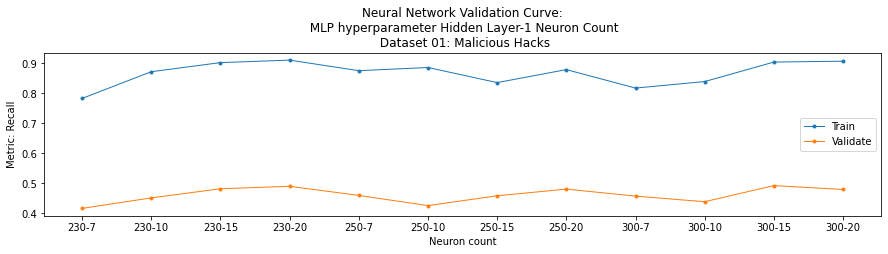

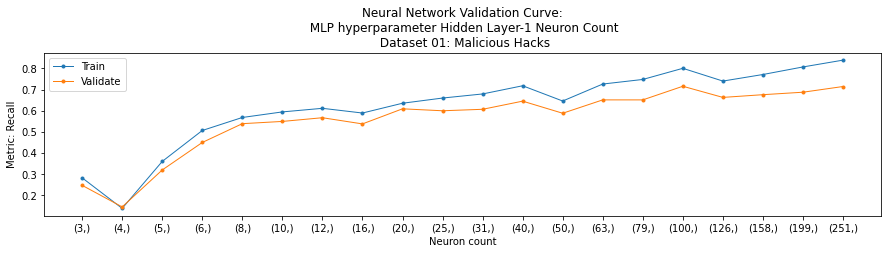

In [140]:
visualize_complexity(mlp_train_s_pca,mlp_test_s_pca, range_list_pca)
visualize_complexity(mlp_train_s_raw,mlp_test_s_raw, range_list_raw)

In [ ]:
train_scores_mean = np.mean(mlp_train_scores, axis=1)
train_scores_std = np.std(mlp_train_scores, axis=1)
test_scores_mean = np.mean(mlp_test_scores, axis=1)
test_scores_std = np.std(mlp_test_scores, axis=1)
print (len(range_list),train_scores_mean.shape,test_scores_mean.shape)

x_strings = []
if len(range_list[0]) == 2:
    x_strings = [ f"{l1}-{l2}" for l1,l2 in  range_list]
elif en(range_list[0]) == 1:
    x_strings = [ f"{l1}" for l1 in  range_list]
print(f"Hidden layers '{x_strings}'")

df_1 = pd.DataFrame({'x':x_strings,'train':train_scores_mean,'test':test_scores_mean})
print(df_1)


fig, axs = plt.subplots(1, 1, figsize=(15,3))
axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=1, marker='.')
axs.plot(df_1['x'], df_1['test'], label='Validate', linewidth=1, marker='.')
axs.legend(); axs.set_ylabel("Metric: Recall"); axs.set_xlabel("Neuron count")
axs.set_title('Neural Network Validation Curve:\n MLP hyperparameter Hidden Layer-1 Neuron Count\n Dataset 01: Malicious Hacks')